## Week 7 "Mixture of Experts"

Welcome to the Tutorial 7. We will discuss about the basic of Mixture of Expert (MoE).

The objectives of this lab are as follows:
1. Technical Understanding about Hard and Soft MoE. MoE is a learning method that can be applied in any field. To do so, we will start with vanilla Multilayer Perceptron model in MNIST.
2. How to implement MoE in Transformers.
3. Make you understand about the basic technical idea about Switch Transformers.

As always, feel free to ask us :)

Assistant: \\
Farid - farid.adilazuarda@mbzuai.ac.ae

## Helper and Import

In [ ]:
!pip install Lightning
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 4.7 MB/s eta 0:00:00


In [ ]:
import torch
from lightning import LightningModule
from lightning import Trainer as LightningTrainer

import matplotlib.gridspec as gridspec
import pandas as pd

import torchvision
from torchmetrics import Accuracy
from copy import deepcopy
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, SwitchTransformersConfig
from datasets import load_dataset
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

from typing import Tuple


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# for every input, check its best expert with the predicted class
def plot_figure(x, y, y_hat, weights):
    # add pad for better visualization
    fig = plt.figure(figsize=(20, 20))

    # Create a 5x5 grid for the main layout
    outer_grid = gridspec.GridSpec(5, 5, wspace=0.4, hspace=0.4)

    # plot the bar chart for the weights and also the predicted class and the label
    # additionally, show the image
    for i in range(5):
        for j in range(5):

            idx = i * 5 + j  # Adjusted to properly index through a 5x5 grid

            # Create a nested grid for each subplot (2 columns: one for image, one for bar chart)
            inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i, j], wspace=0.1, width_ratios=[3, 2])

            # First subplot for the image
            ax1 = plt.Subplot(fig, inner_grid[0])
            ax1.imshow(x[idx].view(28, 28), cmap='gray')  # Uncomment and adjust according to your data
            ax1.set_xticks([])
            ax1.set_yticks([])
            fig.add_subplot(ax1)

            # Second subplot for the bar chart
            ax2 = plt.Subplot(fig, inner_grid[1])
            weights_example =  weights[idx]  #
            y_hat_example = y_hat[idx].argmax()  #
            y_example = y[idx]  #
            expert_example = weights_example.argmax()

            ax2.bar(np.arange(5), weights_example, color='blue', tick_label=np.arange(5))
            ax2.set_title(f'Predicted class: {y_hat_example}')
            ax2.set_xlabel(f'Label: {y_example}, Expert: {expert_example}')
            fig.add_subplot(ax2)

    plt.show()

def extract_moe_contribution(y, y_hat, weights):
    returned_list = []
    for i in range(len(y)):
        returned_list.append({
            "label": y[i].item(),
            "predicted": y_hat[i].argmax().item(),
            "best_experts": weights[i].argmax().item()
        })
    return returned_list

In [ ]:
## Create Our Classification Flow

# train model
class LitClassification(LightningModule):

    def __init__(self, model, do_output_weights: bool = False):
        super(LitClassification, self).__init__()
        self.model = model
        self.do_output_weights = do_output_weights
        self.loss = torch.nn.CrossEntropyLoss()
        self.train_acc = Accuracy('multiclass', num_classes=10)
        self.test_acc = Accuracy('multiclass', num_classes=10)

    def forward(self, x):

        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        if self.do_output_weights:
            y_hat, _ = y_hat

        loss = self.loss(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc(y_hat, y), prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        if self.do_output_weights:
            y_hat, _ = y_hat
        loss = self.loss(y_hat, y)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc(y_hat, y), prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

def check_expert_acc(moemodel, test_loader, lit_test_clf, trainer):
    lit_test_clf.eval()
    print("Expert accuracy")
    for i, expert in enumerate(moemodel.model.experts):
        with torch.no_grad():
            print(f"Expert {i}")
            lit_test_clf.model = expert
            trainer.test(lit_test_clf, test_loader)

def plot_a_single_batch(x, y, y_hat, weights):
    with torch.no_grad():
        plot_figure(x, y, y_hat, weights)

def check_prediction_contribution(moemodel, test_loader):
    contributions = []
    for x, y in test_loader:
        y_hat, weights = moemodel.model(x, output_proba_gates=True)
        contributions.extend(extract_moe_contribution(y, y_hat, weights))
    df = pd.DataFrame(contributions)
    for i in range(5):
        total_expert_contribution = df[df.best_experts == i].shape[0]
        print(f"Expert {i}")
        print(f"Total contribution: {total_expert_contribution}")
        if total_expert_contribution == 0:
            continue
        predicted = df[df.best_experts == i].predicted.value_counts()
        print(predicted)
        # check if the expert is always predicting the same class
        print("Precision based on the best expert:")
        print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])


def probe_result(trainer, moemodel, test_loader, moe_obj):
    trainer.test(moemodel, test_loader)
    ## Check each expert accuracy
    lit_test_clf = LitClassification(moe_obj, do_output_weights=False)
    check_expert_acc(moemodel, test_loader, lit_test_clf, trainer)

    print("Check the contribution of each expert")
    # check forward for a single batch
    x, y = next(iter(test_loader))
    print(x, y)
    y_hat, weights = moemodel.model(x, output_proba_gates=True)
    print(y_hat)

    # convert them to numpy
    y_hat = y_hat.detach().numpy()
    weights = weights.detach().numpy()

    # plot the figure
    plot_a_single_batch(x, y, y_hat, weights)

    # loop through the test loader and extract the contribution of each expert
    print("Extracting the contribution of each expert")
    check_prediction_contribution(moemodel, test_loader)

# Initialize our basic expert model


In [ ]:
class ExpertModel(torch.nn.Module):
  def __init__(self, in_features, out_features):
      super(ExpertModel, self).__init__()
      self.in_features = in_features
      self.out_features = out_features
      self.layer1 = torch.nn.Linear(in_features, out_features)
      self.layer2 = torch.nn.Linear(out_features, out_features)

  def forward(self, x: torch.Tensor):
      x = torch.nn.functional.relu(self.layer1(x))
      x = self.layer2(x)
      return x


def generate_n_experts(n: int, in_features: int, out_features: int):
    # put your code here to generate experts
    return [ExpertModel(in_features, out_features) for _ in range(n)]

## Initialize data

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)


100%|██████████| 9912422/9912422 [00:00<00:00, 261457794.83it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 98967070.12it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82357532.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18531642.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Define our MoE objects

Illustration of MoE:

![image.png](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhbsjq4iseHi-Azxcj0irBjGkma0yd4geSPPombnJSdd5dyzTguUU2pdFfZu4G38G4F4TiymUOaIkQnXGVAix5x8wF3-9Ov3NJwWaEZNvJY84CWCgU5MbUYI_DjKa_BvalTHu3eyfCJGR89UqwskKngsppDy94Gahz3HAoKLh2vmh-Jzb7ZedRI91OwFw/s960/image1.jpg)

From: https://blog.research.google/2022/11/mixture-of-experts-with-expert-choice.html?m=1

To describe the Mixture of Experts (MoE) model based on the provided Python class definitions, we can break it down into the algorithm's key components and functionalities. The MoE model typically consists of two main parts: a gating mechanism to decide the weighting of each expert's output, and a set of expert models that provide specialized knowledge or processing.

You may implement these:

### 1. **Gate Layer** (AKA Router)

The Gate Layer's primary role is to dynamically allocate input data to different experts based on the input features. This is achieved through a two-layer neural network with a softmax activation on the output layer to ensure that the weights sum up to one.

Given an input tensor $x \in \mathbb{R}^{batch\_size \times in\_features}$, the gating mechanism works as follows:

1. **First Layer Transformation**: Apply a linear transformation followed by a ReLU activation function.
    $$
    x' = ReLU(W_1 x + b_1)
    $$
    where $W_1 \in \mathbb{R}^{hidden\_size \times in\_features}$ and $b_1 \in \mathbb{R}^{hidden\_size}$ are the weights and biases of the first layer.

2. **Second Layer Transformation**: Apply another linear transformation to map to the space of experts.
    $$
    z = W_2 x' + b_2
    $$
    where $W_2 \in \mathbb{R}^{num\_experts \times hidden\_size}$ and $b_2 \in \mathbb{R}^{num\_experts}$.

3. **Softmax Activation**: The softmax function is applied to obtain the gating probabilities, which indicate the weight of each expert's contribution.
    $$
    \text{gates} = Softmax(z) = \frac{e^{z_i}}{\sum_{j=1}^{num\_experts} e^{z_j}}
    $$
    for each expert $i$, ensuring the output is a probability distribution over experts.

### 2. **MoE Layer**

The MoE Layer orchestrates the overall processing, combining the expert models' outputs based on the gating probabilities. For an input $x$, the process is as follows:

1. **Gating Probabilities**: Compute the gating probabilities for each expert as described above.
2. **Expert Processing**: Each expert model processes the input independently.
    $$
    E_i(x) \quad \text{for each expert} \; i
    $$
3. **Output Combination**: The outputs of the experts are combined based on the gating probabilities. This can be represented as a weighted sum:
    $$
    O(x) = \sum_{i=1}^{num\_experts} \text{gates}_i \cdot E_i(x)
    $$
    where \(O(x)\) is the final output for the input $x$, and $\text{gates}_i$ is the gating probability for expert $i$.

This framework allows the MoE model to leverage the strengths of different experts for different parts of the input space, potentially improving the model's overall performance on complex tasks with diverse data.

In [ ]:
class GateLayer(torch.nn.Module):
    def __init__(self, in_features, hidden_size, num_experts):
        super(GateLayer, self).__init__()
        # continue the main attributes for the gate layer
        hidden_size = hidden_size
        self.in_features = in_features
        self.num_experts = num_experts
        self.layer1 = torch.nn.Linear(in_features, hidden_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.layer2 = torch.nn.Linear(hidden_size, num_experts)

    def forward(self, x):
      x = torch.nn.functional.relu(self.layer1(x))
      x = self.layer2(x)
      return self.softmax(x)

class MoELayer(torch.nn.Module):
    def __init__(self, experts: list[ExpertModel], gate_layer: GateLayer, is_sequence: bool = False):
        super(MoELayer, self).__init__()
        # clone expert model to create num_experts copies and reset their parameters
        self.experts = torch.nn.ModuleList(experts)
        self.num_experts = len(experts)

        self.gate_layer = gate_layer
        self.relu = torch.nn.ReLU()
        self.is_sequence = is_sequence

        self.permutation_dimension = (1,2,0,3) if is_sequence else (1,0,2)


    def forward(self, x, output_proba_gates=False):
        gates_proba = self.gate_layer(x)  # (batch_size, num_experts)
        # below is slow!!!!
        # expert_outputs = torch.stack([expert(x) for expert in self.experts])
        expert_outputs = torch.stack([expert(x) for expert in zip(self.experts, gates_proba) if gates_proba > 0 else torch.zeros()])
        # (num_experts, batch_size, seq_len, out_features)
        # stack expert outputs and gates
        # (batch_size, seq_len, num_experts, out_features)
        expert_outputs = expert_outputs.permute(*self.permutation_dimension)
        gates = gates_proba.unsqueeze(3 if self.is_sequence else 2)  # (batch_size, seq_len, num_experts, 1)
        if self.is_sequence:
          gates = gates.expand(-1, -1, -1, expert_outputs.size(3))  # (batch_size, seq_len, num_experts, out_features)
        else:
          gates = gates.expand(-1, -1, expert_outputs.size(2))  # (batch_size, num_experts, out_features)
        # print(gates.shape, expert_outputs.shape)
        # weighted sum of expert outputs
        output = torch.sum(gates * expert_outputs, dim=2 if self.is_sequence else 1)  # (batch_size, out_features)
        if output_proba_gates:
            return output, gates_proba
        return output


In [ ]:
# create model
gate = GateLayer(
    in_features=784,
    hidden_size=100,
    num_experts=5,
)

experts = generate_n_experts(
    n=5,
    in_features=784,
    out_features=10
)

moe = MoELayer(
    experts=experts,
    gate_layer=gate,
    is_sequence=False
)

moemodel = LitClassification(moe)

trainer = LightningTrainer(max_epochs=1)

trainer.fit(moemodel, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MoELayer           | 118 K 
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
118 K     Trainable params
0         Non-t

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
trainer.test(moemodel, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9445000290870667     │
│         test_loss         │    0.19368180632591248    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19368180632591248, 'test_acc': 0.9445000290870667}]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9444999694824219     │
│         test_loss         │    0.19368179142475128    │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert accuracy
Expert 0


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4156999886035919     │
│         test_loss         │     3.610940456390381     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 1


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2654999792575836     │
│         test_loss         │     5.010535717010498     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 2


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.21169999241828918    │
│         test_loss         │     4.062795162200928     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 3


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3520999848842621     │
│         test_loss         │     4.859294414520264     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 4


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2847999930381775     │
│         test_loss         │    2.1291069984436035     │
└───────────────────────────┴───────────────────────────┘

Check the contribution of each expert
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
tensor([[-2.1947e+00, -1.6744e+00, -6.4940e-01,  2.0715e+00, -5.7574e+00,
         -3.0424e+00, -6.8451e+00,  7.5021e+00, -1.9395e+00, -2.1576e-01],
        [-6.4228e-01, -2.2330e+00,  4.7539e+00, -7.6269e-01, -1.5804e+00,
         -1.1465e+00, -5.6769e-01, -3.1186e+00, -1.5161e+00, -5.4835e+00],
        [-5.1597e+00,  4.1234e+00, -2.3861e+00, -2.9159e+00, -1.8499e+00,
         -3.4167e+00, -1.4703e+00, -2.2444e+00, -5.4384e-01, -2.4620e+00],
        [ 6.7437e+00, -8.5103e+00, -5.7765e-01, -2.8250e+00, -4.7889e+00,
         -9.1986e-01,  6.4053e-01, -2.4335e+00, -2.9328e+00, -2.7379e+00],

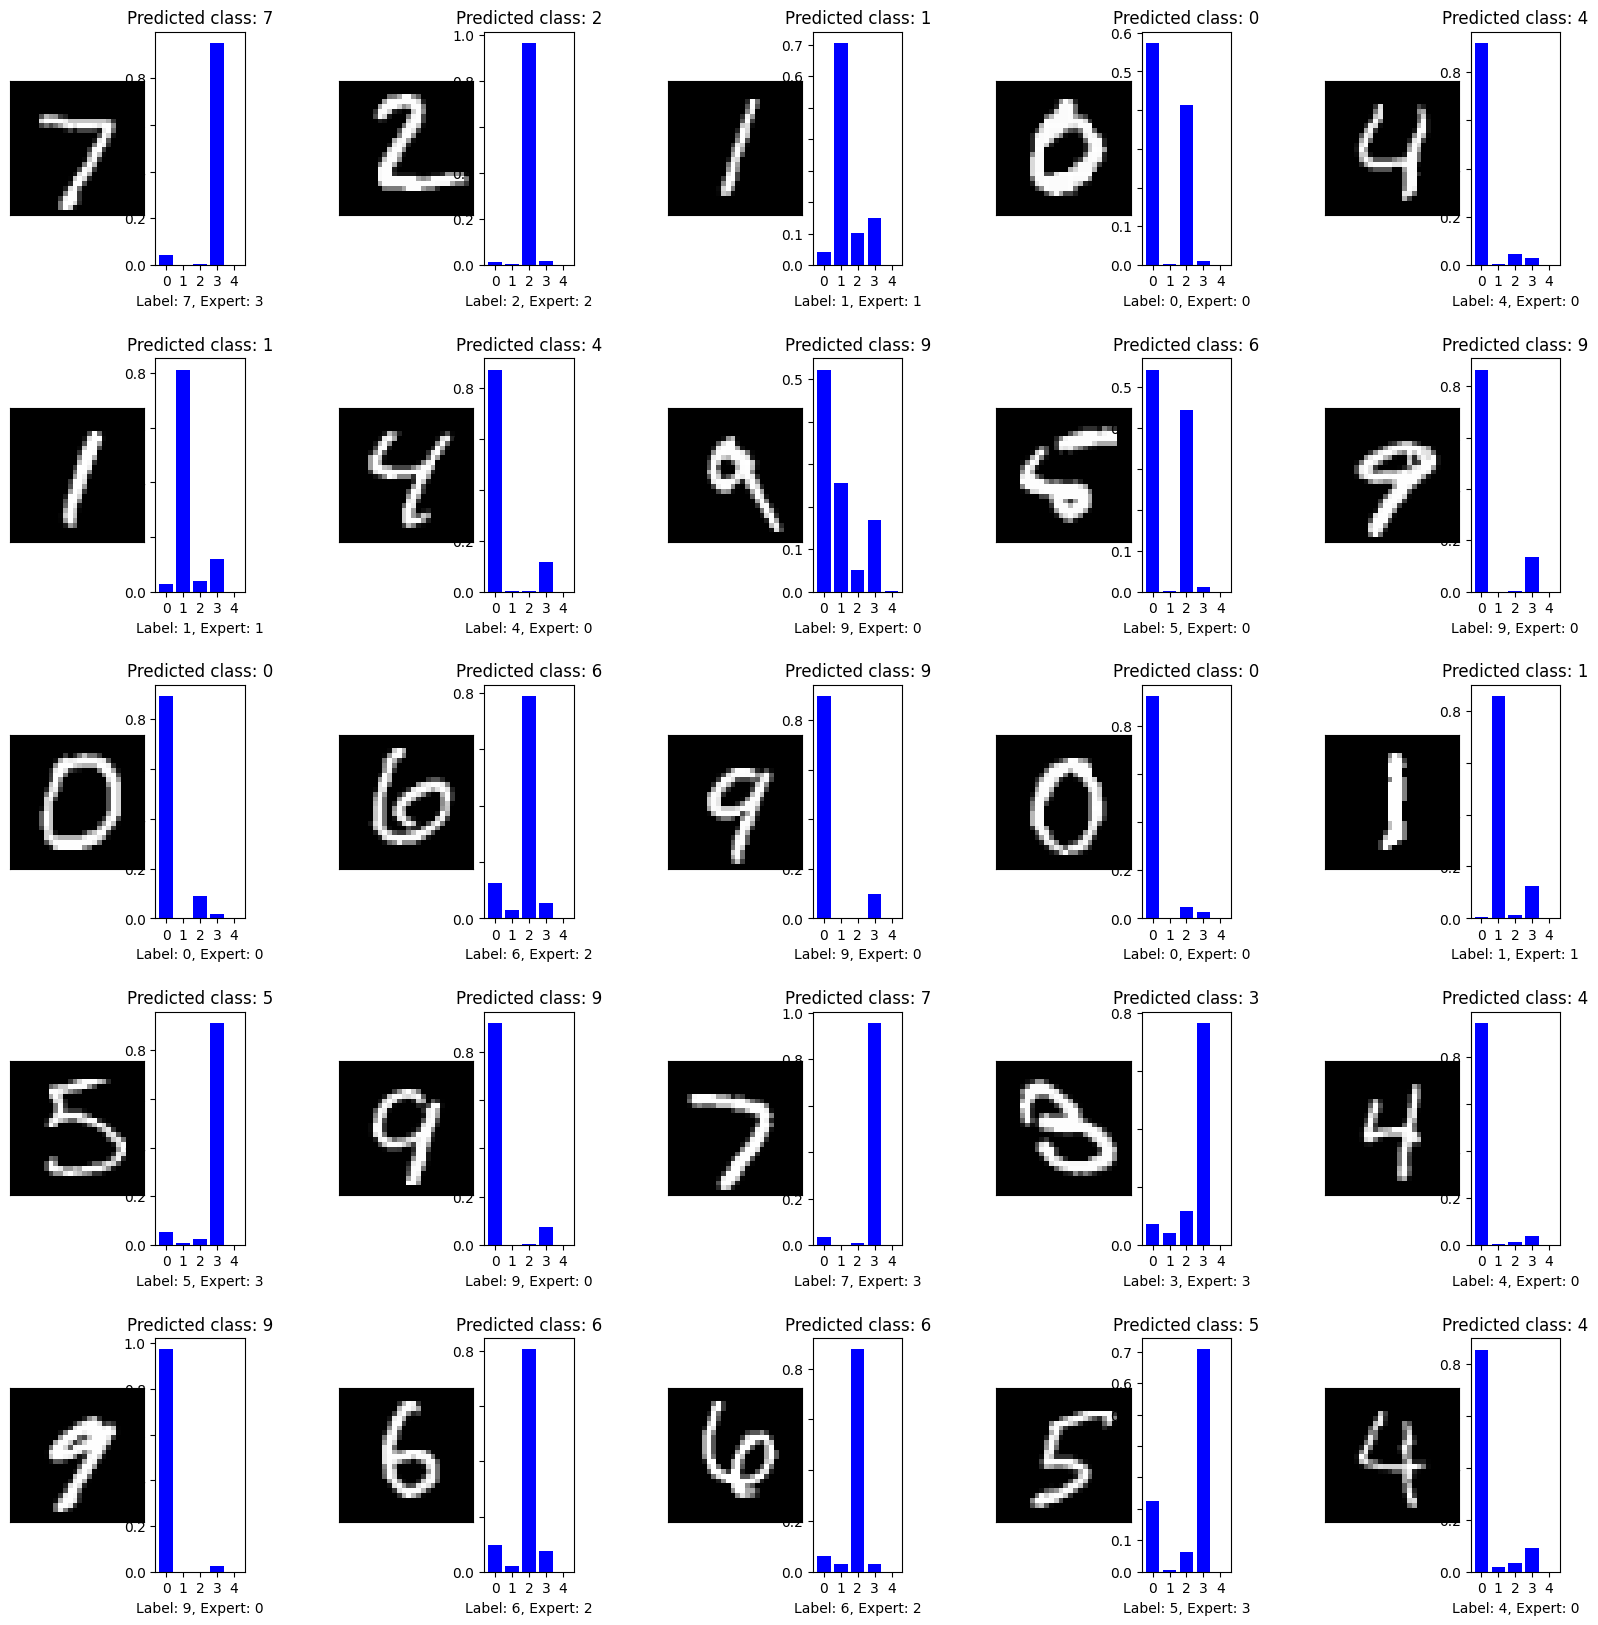

Extracting the contribution of each expert
Expert 0
Total contribution: 3394
0    983
4    970
9    958
5    274
8    141
7     54
6      9
2      4
3      1
Name: predicted, dtype: int64
Precision based on the best expert:
0.9490276959340012
Expert 1
Total contribution: 1137
1    1095
8      14
5      13
2       7
7       5
4       2
6       1
Name: predicted, dtype: int64
Precision based on the best expert:
0.9771328056288479
Expert 2
Total contribution: 1952
2    961
6    946
3     16
0     10
4      7
8      6
5      4
1      2
Name: predicted, dtype: int64
Precision based on the best expert:
0.9569672131147541
Expert 3
Total contribution: 3517
3    1054
7     950
8     905
5     531
2      53
9      17
1       7
Name: predicted, dtype: int64
Precision based on the best expert:
0.9226613591128803
Expert 4
Total contribution: 0


<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])


In [ ]:
probe_result(trainer, moemodel, test_loader, moe)

## Hard Selection

Below is a variant of the gating mechanism in a Mixture of Experts (MoE) model, focusing on selecting only the top \(k\) experts for each input. This approach is designed to enhance the model's efficiency and effectiveness by concentrating computation on the most relevant experts for a given input. Here is an explanation of how this gating mechanism works, incorporating noise for load balancing and the selection of top \(k\) experts.

Implement these inside the class:


### **Tunable Noise for Load Balancing**

The `_get_tunable_noise` method introduces a novel aspect of the `GateLayerTopK`: adding tunable noise to the gating mechanism. This noise is weighted by the input data and a learnable weight parameter (`w_noise`), intended to diversify the inputs to the experts and balance their workload. Use any arbitrary noise. The noise is calculated as follows:

$$
\text{weighted_noise} = \text{ReLU}(XW_{noise})
$$

where $(X)$ is the input tensor and $(W_{noise})$ is the learned noise weight matrix. The noise added to the gating signal is then a random noise tensor, scaled by this weighted noise.

### 3. **Forward Pass**

During the forward pass, the input \(X\) undergoes several transformations:

1. **Initial Processing**: The input is first passed through a ReLU-activated linear layer (`layer1`), then through another linear transformation (`layer2`).

2. **Noise Addition**: Tunable noise is added to the gating signals to encourage load balancing among experts.

4. **Top-k Expert Selection**:
   - The gating mechanism is adjusted to only consider the top $(k)$ experts for each input. This is done by setting the scores of all but the top $(k)$ experts to $(-inf)$ using the following steps:
     1. Identify the indices of the bottom $(n-k)$ experts (where $(n)$ is the total number of experts) for each input based on their gating scores.
     2. Use the `scatter` function to set the scores of these bottom $(n-k)$ experts to $-inf$, effectively excluding them from the final softmax calculation.
   
5. **Softmax Activation**: Finally, a softmax is applied to the adjusted gating scores, ensuring that the output is a sparse probability distribution that sums to one, focusing solely on the top $(k)$ experts for each input.

### Summary

The `GateLayerTopK` introduces a selective and noise-enhanced gating mechanism for MoE models, aiming to improve both the efficiency of computation by focusing on the most relevant experts and the diversity of expert utilization through tunable noise. This approach can lead to better performance and more balanced utilization of experts in complex tasks.

### Nice to try

Play around with the top-k, what do you find?

In [ ]:
# We select k experts here
# We modify the gate

class GateLayerTopK(torch.nn.Module):
    def __init__(self, in_features, hidden_size, num_experts, top_k: int):
        super(GateLayerTopK, self).__init__()
        self.top_k = top_k
        self.in_features = in_features
        self.num_experts = num_experts
        self.layer1 = torch.nn.Linear(in_features, hidden_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.layer2 = torch.nn.Linear(hidden_size, num_experts)
        self.w_g = torch.nn.Parameter(torch.zeros(hidden_size, num_experts))
        self.w_noise = torch.nn.Parameter(torch.zeros(in_features, num_experts))


    def _get_tunable_noise(self, x):
        """Add noise to the input for load balancing."""
        weighted_noise = torch.matmul(x, self.w_noise)
        return torch.randn_like(weighted_noise) * weighted_noise

    def forward(self, x: torch.Tensor):
        noise = self._get_tunable_noise(x)
        x = torch.nn.functional.relu(self.layer1(x))
        x = self.layer2(x)
        x = x + noise

        # Addition
        # Implement selection for the top k experts
        # x = (batch_size, experts)
        top_k, bottom_last = x.topk(k=self.top_k, dim = 1, largest=False)
        x = x.scatter(dim = 1,index=bottom_last, value=-float("inf"))

        ## End of addition
        return self.softmax(x)

In [ ]:
# create model
gate2 = GateLayerTopK(
    in_features=784,
    hidden_size=100,
    num_experts=5,
    top_k=2,
)

experts2 = generate_n_experts(
    n=5,
    in_features=784,
    out_features=10
)

moe2 = MoELayer(
    experts=experts2,
    gate_layer=gate2,
    is_sequence=False
)

moemodel2 = LitClassification(moe2)

trainer = LightningTrainer(max_epochs=1)

trainer.fit(moemodel2, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MoELayer           | 123 K 
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
123 K     Trainable params
0         Non-t

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
trainer.test(moemodel2, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.939300000667572     │
│         test_loss         │    0.21204301714897156    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.21204301714897156, 'test_acc': 0.939300000667572}]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9398999810218811     │
│         test_loss         │     0.209328293800354     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert accuracy
Expert 0


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11469999700784683    │
│         test_loss         │    2.6394994258880615     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 1


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3455999791622162     │
│         test_loss         │    3.2126646041870117     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 2


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.29659998416900635    │
│         test_loss         │     2.965061664581299     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 3


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.24879999458789825    │
│         test_loss         │     4.314909934997559     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 4


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.28369998931884766    │
│         test_loss         │     3.938995599746704     │
└───────────────────────────┴───────────────────────────┘

Check the contribution of each expert
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
tensor([[-1.7832e+00, -3.3816e+00, -7.3740e-01, -4.2306e-01, -2.0756e+00,
         -3.1965e+00, -3.6409e+00,  8.1126e+00, -1.5136e+00,  1.6838e+00],
        [-5.0274e+00, -9.4982e+00,  6.8636e+00, -1.7127e-01, -5.7809e+00,
         -1.5875e+00, -2.0339e+00, -2.8967e+00, -2.6278e+00, -7.5561e+00],
        [-2.6398e+00,  4.6434e+00, -3.9152e-01, -2.5754e+00, -1.9825e+00,
         -2.7818e+00, -2.1260e+00, -1.4294e-01, -6.1391e-01, -4.5503e+00],
        [ 7.5886e+00, -7.4148e+00, -2.1165e+00, -2.7729e+00, -1.1719e+00,
          2.5813e-01, -1.2557e+00, -2.7815e+00, -3.9939e+00, -1.3980e+00],

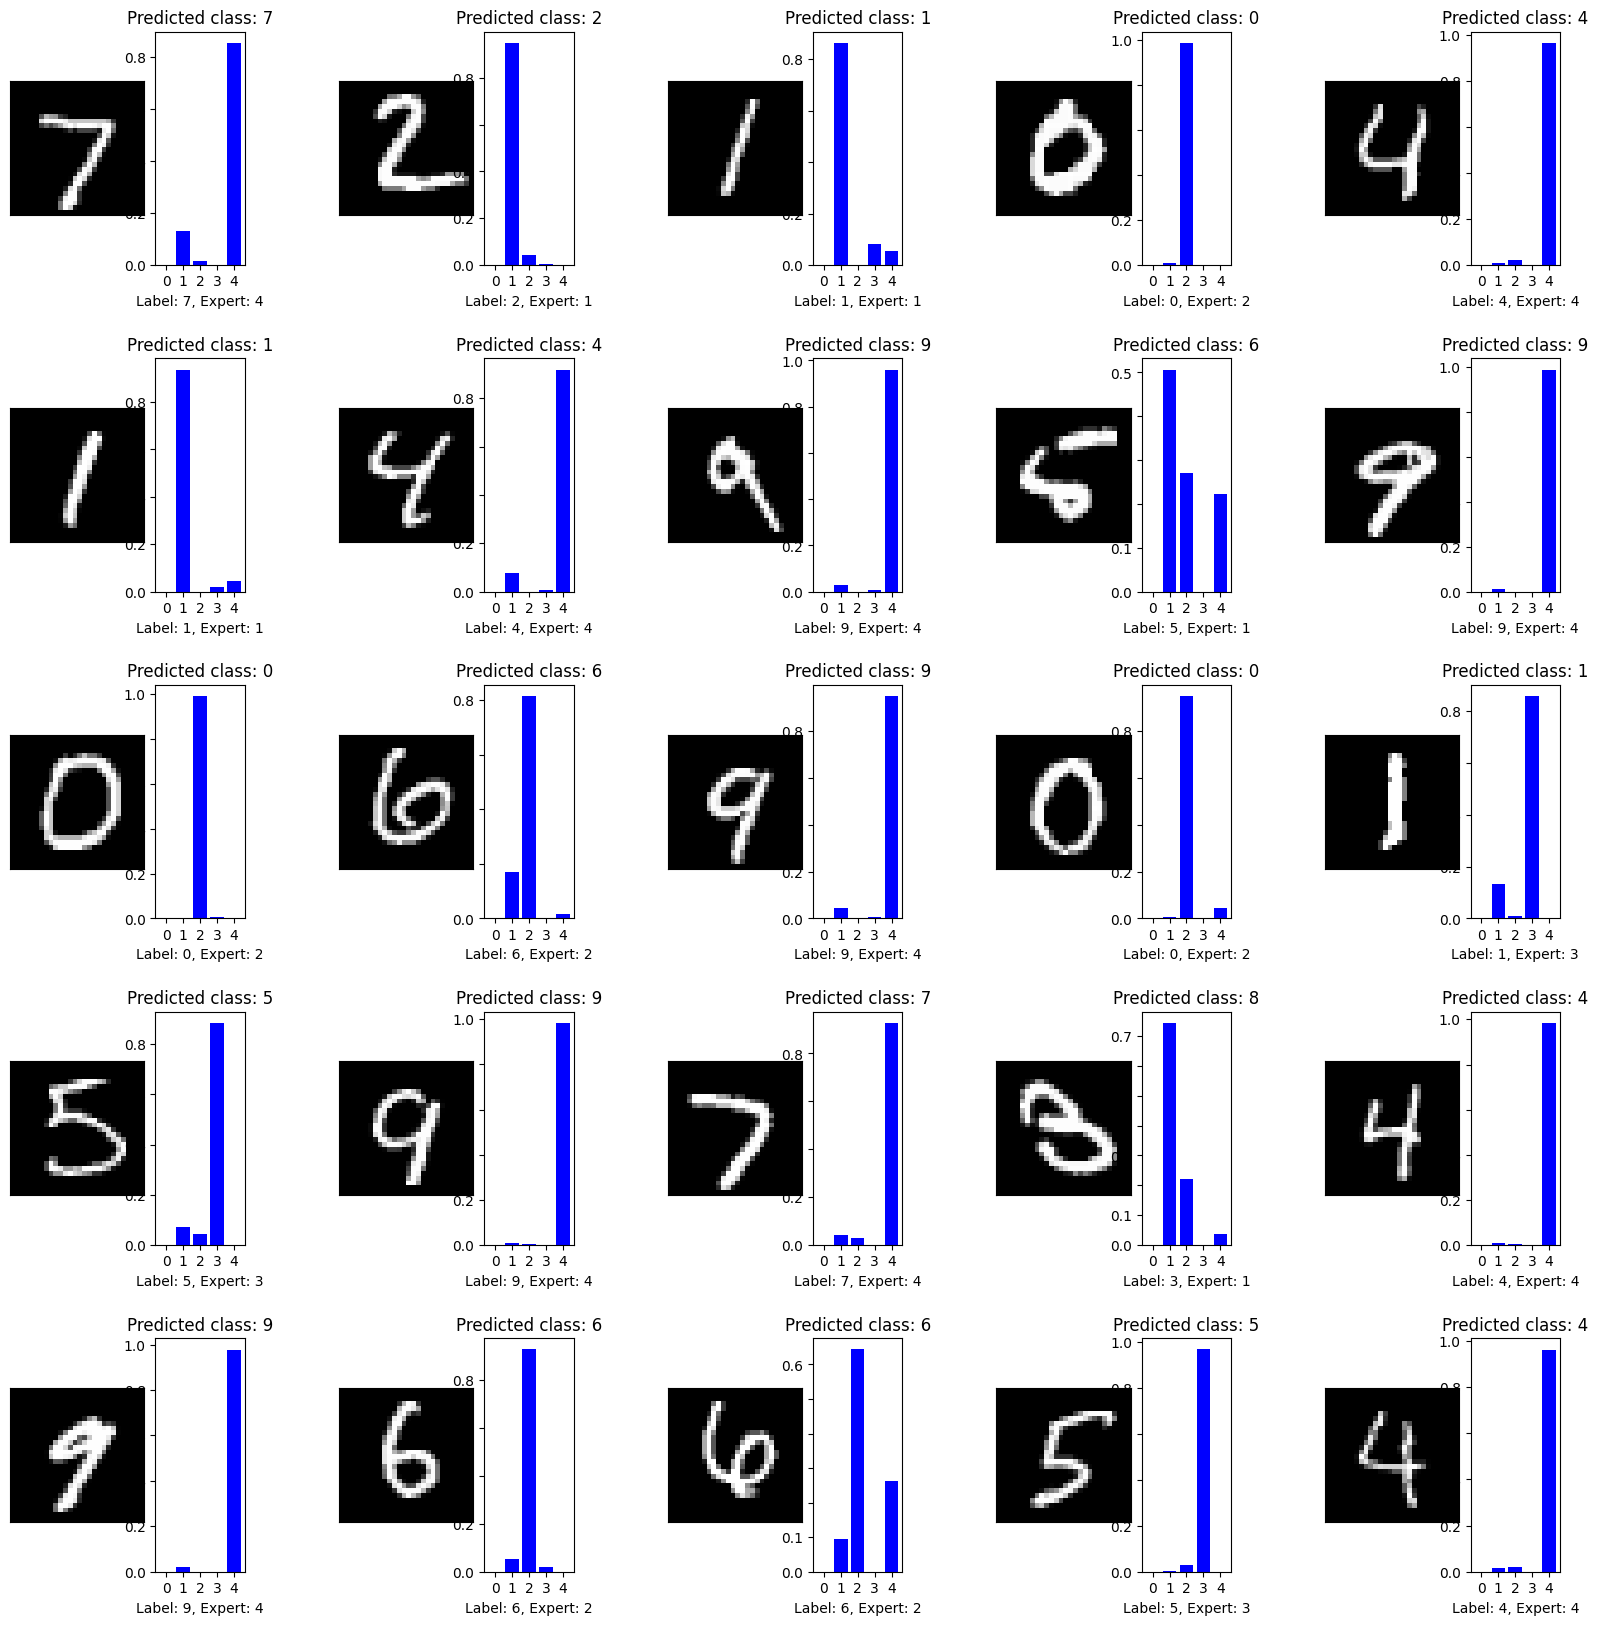

Extracting the contribution of each expert
Expert 0
Total contribution: 0
Expert 1
Total contribution: 3032
8    1026
2     914
1     757
5     177
3      96
7      36
4      15
6       9
9       2
Name: predicted, dtype: int64
Precision based on the best expert:
0.9261213720316622
Expert 2
Total contribution: 2120
0    998
6    947
2     94
3     34
5     32
4     10
8      3
9      2
Name: predicted, dtype: int64
Precision based on the best expert:
0.9537735849056603
Expert 3
Total contribution: 1869
3    819
5    657
1    390
2      1
8      1
9      1
Name: predicted, dtype: int64
Precision based on the best expert:
0.9668271803103263
Expert 4
Total contribution: 2979
4    1027
7     990
9     943
3       7
8       6
5       3
2       2
1       1
Name: predicted, dtype: int64
Precision based on the best expert:
0.9264853977844915


<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])


In [ ]:
probe_result(trainer, moemodel2, test_loader, moe2)

## Load Balancing

As you see above, some experts have smaller contributions. If you want to make the experts work equally, you can do load balancing.

There are several ways to do this. We will pick this algorithm instead (From [This paper](https://arxiv.org/abs/1312.4314))

To provide a more detailed explanation of the `GateLayerTopKLoadBalancing` class with equations, let's break down its functionality into mathematical components:


#### 5. **Load Balancing (Optional)**

If load balancing is enabled, the following steps are taken to adjust the expert weights based on historical load:

- Compute the step's total assignment to each expert:

$ \text{step_total_assignment} = \sum_{i=1}^{batch\_size} P_i $

- Update the running total assignment and calculate the mean total assignment:

$ \text{running_total_assignment} \ += step\_total\_assignment $

$ \text{mean_total_assignment} = \frac{1}{num\_experts} \sum_{j=1}^{num\_experts} \text{running_total_assignment}_j $

- Apply an expert mask based on the load balancing threshold:

$$ \text{expert_mask}_j = \begin{cases}
  0 & \text{if } \text{running_total_assignment}_j - \text{mean_total_assignment} > threshold \\
  1 & \text{otherwise}
\end{cases} $$

- Adjust expert weights and reapply softmax:

$ P_{adjusted} = P \times \text{expert_mask} $

$ P_{final} = \text{Softmax}(P_{adjusted}) $

### Summary

The `GateLayerTopKLoadBalancing` class implements a gating mechanism that selects the top \(k\) experts based on modified gating scores, applies tunable noise for variability, and optionally balances the load among experts to prevent over-reliance on specific ones. This approach aims to enhance efficiency and performance by dynamically allocating computational resources in a Mixture of Experts model.

In [ ]:
# We select k experts here
# We modify the gate

class GateLayerTopKLoadBalancing(torch.nn.Module):
    def __init__(self, in_features, hidden_size, num_experts, top_k: int, balance=True, threshold=0.1):
        super(GateLayerTopKLoadBalancing, self).__init__()
        self.top_k = top_k
        self.in_features = in_features
        self.num_experts = num_experts

        # Gate non linearity + weighting
        self.layer1 = torch.nn.Linear(in_features, hidden_size)
        self.softmax = torch.nn.Softmax(dim=1)
        self.layer2 = torch.nn.Linear(hidden_size, num_experts)

        self.balance=balance
        self.threshold=threshold
        self.running_total_assignment = torch.zeros(num_experts)

        # Tunable noise
        self.w_g = torch.nn.Parameter(torch.zeros(in_features, num_experts))
        self.w_noise = torch.nn.Parameter(torch.zeros(in_features, num_experts))

    def _get_tunable_noise(self, x):
        """Add noise to the input for load balancing. This will be elaborated later!"""
        weighted_noise = torch.matmul(x, self.w_noise)
        return torch.randn_like(weighted_noise) * weighted_noise

    def forward(self, x: torch.Tensor):
        noise = self._get_tunable_noise(x)
        self.running_total_assignment = self.running_total_assignment.to(x.device)
        x = torch.nn.functional.relu(self.layer1(x))
        x = self.layer2(x)
        x = x + noise

        # Addition
        # We select bottom k experts and make them -infinity
        if not self.balance:
          k_bot = self.num_experts - self.top_k
          _, bottom_k_indices = x.topk(k=k_bot, dim=1, largest=False)
          x = x.scatter(dim=1, index=bottom_k_indices, value=-float("inf"))
          ## End of addition

          expert_weights = self.softmax(x)

        # Implement the load balancing
        else:
            expert_weights = self.softmax(x)
            # Add a load balancing mechanism here
            # Calculate the assignment for each expert
            step_total_assignment = torch.sum(expert_weights, dim=0)
            self.running_total_assignment += step_total_assignment
            mean_total_assignment = torch.mean(self.running_total_assignment)

            expert_mask = self.running_total_assignment.clone().to(x.device).detach()

            expert_mask[self.running_total_assignment - mean_total_assignment > self.threshold] = 0
            expert_mask[self.running_total_assignment - mean_total_assignment <= self.threshold] = 1

            expert_weights = expert_weights * expert_mask
            k_bot = self.num_experts - self.top_k
            _, bottom_k_indices = expert_weights.topk(k=k_bot, dim=1, largest=False)
            expert_weights = expert_weights.scatter(dim=1, index=bottom_k_indices, value=-float("inf"))

            expert_weights = torch.nn.functional.softmax(expert_weights, dim=1)


        return expert_weights

In [ ]:
moemodel

LitClassification(
  (model): MoELayer(
    (experts): ModuleList(
      (0-4): 5 x ExpertModel(
        (layer1): Linear(in_features=784, out_features=10, bias=True)
        (layer2): Linear(in_features=10, out_features=10, bias=True)
      )
    )
    (gate_layer): GateLayer(
      (layer1): Linear(in_features=784, out_features=100, bias=True)
      (softmax): Softmax(dim=1)
      (layer2): Linear(in_features=100, out_features=5, bias=True)
    )
    (relu): ReLU()
  )
  (loss): CrossEntropyLoss()
  (train_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)

In [ ]:
# create model
gate2 = GateLayerTopKLoadBalancing(
    in_features=784,
    hidden_size=100,
    num_experts=5,
    top_k=2,
)

experts2 = generate_n_experts(
    n=5,
    in_features=784,
    out_features=10
)

moe3 = MoELayer(
    experts=experts2,
    gate_layer=gate2,
    is_sequence=False
)

moemodel3 = LitClassification(moe3)

trainer = LightningTrainer(max_epochs=1)

trainer.fit(moemodel3, train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MoELayer           | 126 K 
1 | loss      | CrossEntropyLoss   | 0     
2 | train_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
126 K     Trainable params
0         Non-t

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9115999937057495     │
│         test_loss         │    0.3166133165359497     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert accuracy
Expert 0


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5507000088691711     │
│         test_loss         │     1.335123062133789     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 1


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4447000026702881     │
│         test_loss         │    1.6158491373062134     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 2


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.838699996471405     │
│         test_loss         │    0.5018813014030457     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 3


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6069999933242798     │
│         test_loss         │    1.3379560708999634     │
└───────────────────────────┴───────────────────────────┘

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Expert 4


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6873999834060669     │
│         test_loss         │    1.4102598428726196     │
└───────────────────────────┴───────────────────────────┘

Check the contribution of each expert
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
tensor([[-5.9047e+00, -4.5787e+00, -8.6786e-01,  2.0599e+00, -4.4288e+00,
         -3.3325e+00, -7.1184e+00,  7.0839e+00,  2.4816e-01,  7.5358e-01],
        [-2.0607e+00, -5.0945e+00,  4.5229e+00,  8.6793e-01, -3.9677e+00,
          1.7000e-01,  1.7854e+00, -6.9474e+00, -3.7338e-01, -3.6704e+00],
        [-3.6905e+00,  3.0207e+00, -4.6423e-01, -1.0435e+00, -2.5739e+00,
         -2.3935e+00, -1.6303e+00, -1.9338e+00, -1.6909e+00, -2.2528e+00],
        [ 5.7879e+00, -8.4412e+00, -3.3801e+00, -2.4319e+00, -4.0157e+00,
         -1.6375e+00, -2.0081e+00, -2.7715e+00, -2.7616e+00, -3.7315e+00],

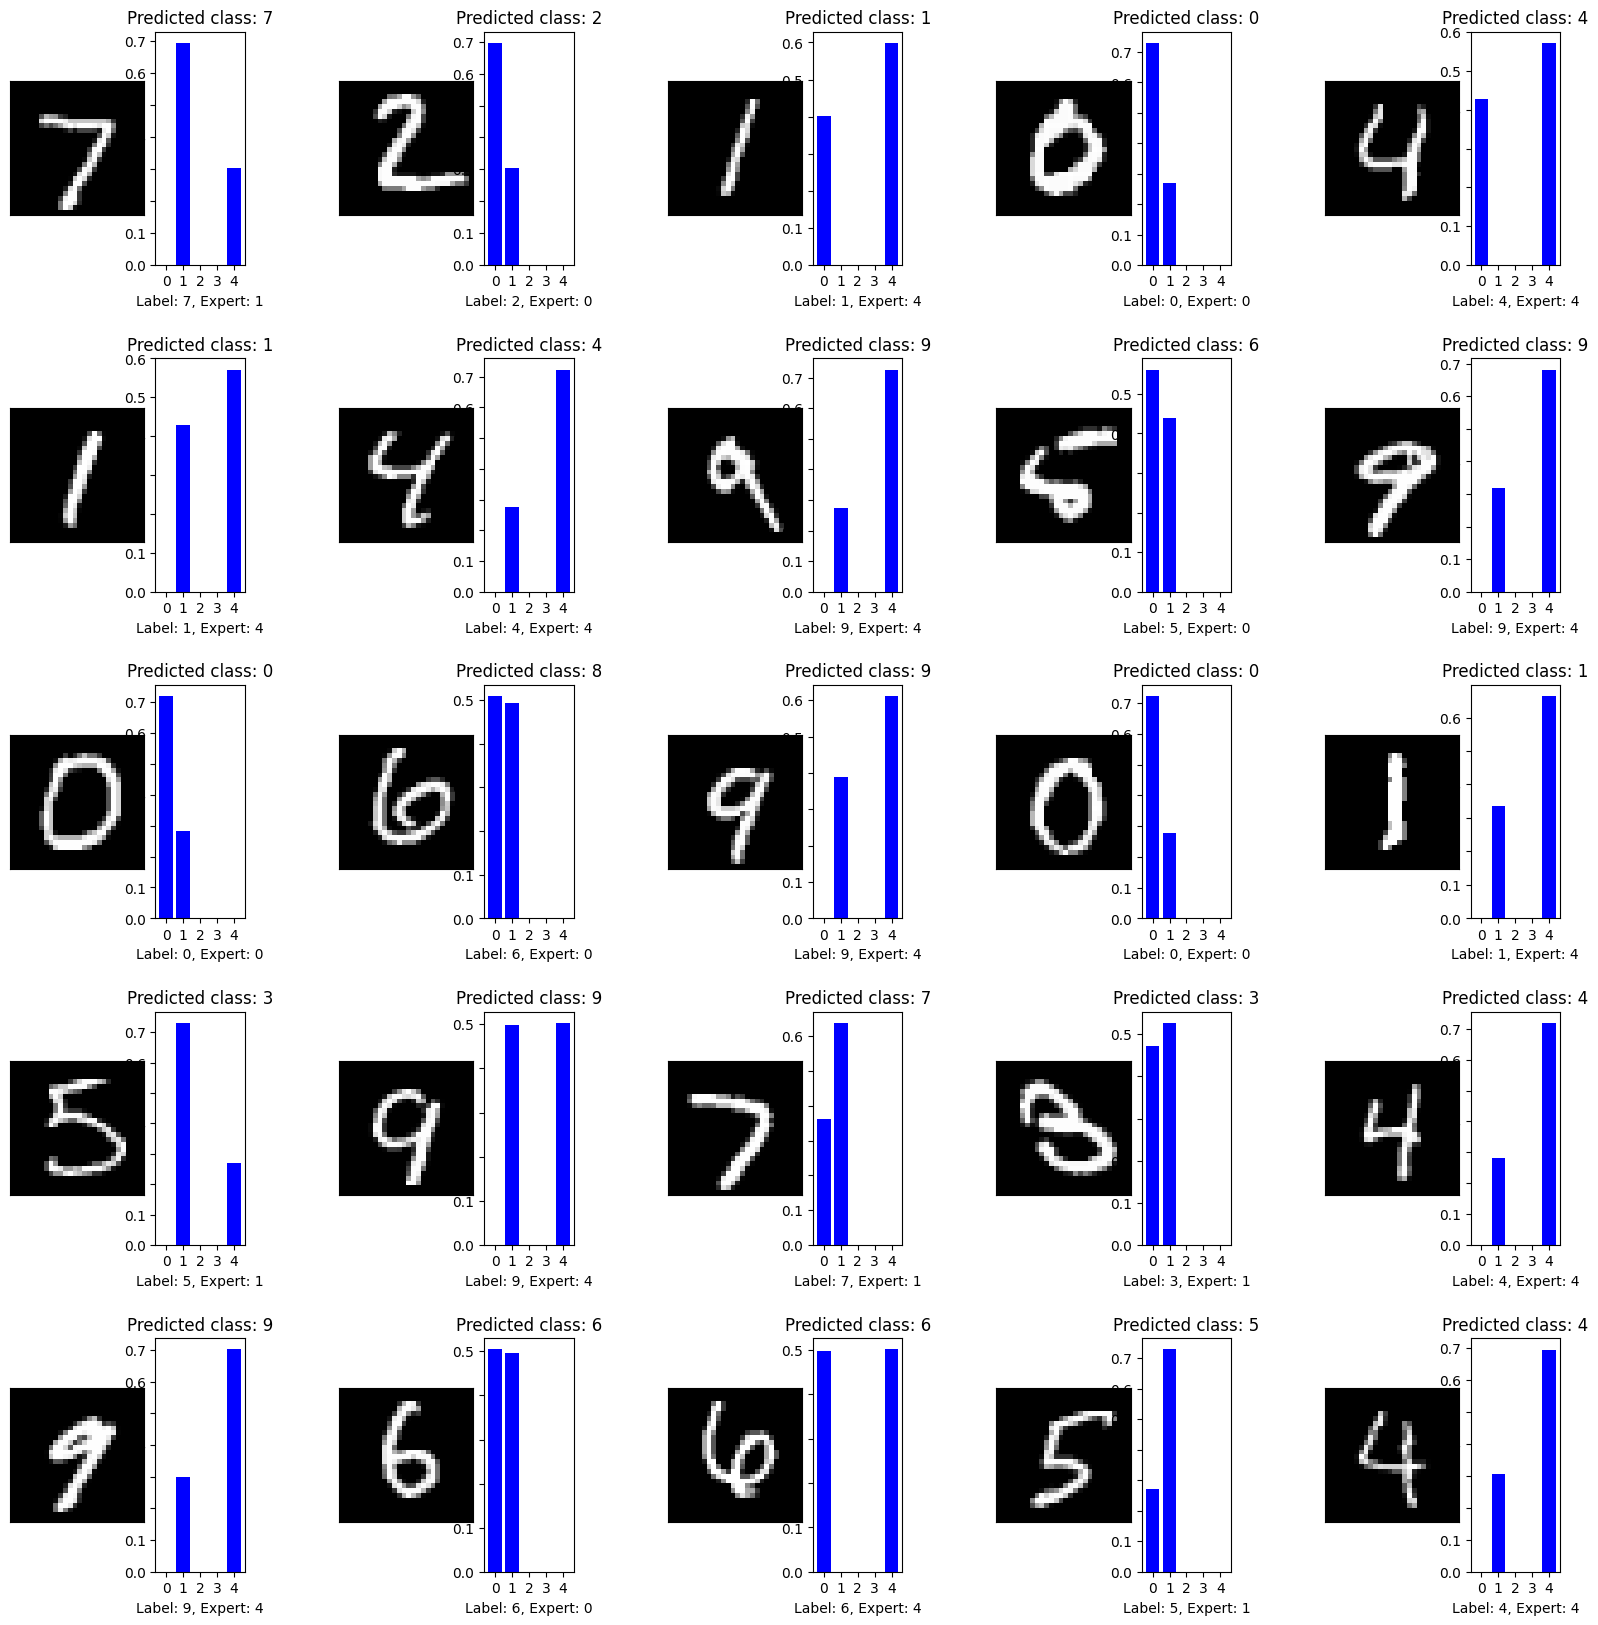

Extracting the contribution of each expert
Expert 0
Total contribution: 3042
2    1006
0     988
6     817
8      54
4      51
9      43
7      27
3      27
1      21
5       8
Name: predicted, dtype: int64
Precision based on the best expert:
0.9227481919789612
Expert 1
Total contribution: 3263
3    1008
5     792
8     784
7     563
9      39
2      37
0      14
1      13
6      12
4       1
Name: predicted, dtype: int64
Precision based on the best expert:
0.893349678210236
Expert 2
Total contribution: 0
Expert 3
Total contribution: 0
Expert 4
Total contribution: 3695
1    1101
9     920
4     914
7     416
8     168
6      92
3      45
5      27
2      11
0       1
Name: predicted, dtype: int64
Precision based on the best expert:
0.9190798376184033


<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])
<ipython-input-22-a65e01207583>:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[df.best_experts == i][df.predicted == df.label].shape[0] / df[df.best_experts == i].shape[0])


In [ ]:
probe_result(trainer, moemodel3, test_loader, moe3)

## You get the idea how to implement MoE!

Now, let's move on how to implement them to transformers.

Basically, we can implement MoE in any layer. However,  research communities tend to implement MoE in intermediate layer of each self-attention layer.

So, let's follow the trend :\)

We will inject MoE to a Bert-Tiny (Substantially mini BERT) to train a model for intent classification task using MASSIVE dataset.

Implement if `is_sequence` is True!

In [ ]:
def inject_moe(model, moe_target, moe_layer_cls, gate_layer_cls, num_experts = 5):
  for moe_address in moe_target:
    # Loop to get the module object
    moe_address, is_sequence = moe_address
    splitted_moe_address = moe_address.split(".")
    parents = splitted_moe_address[:-1]
    replaced_child = splitted_moe_address[-1]
    parent_module = model
    for parent in parents:
      parent_module = getattr(parent_module, parent)

    # we clone this weights
    child = getattr(parent_module, replaced_child)
    experts = [deepcopy(child) for i in range(num_experts)]
    gate_layer = gate_layer_cls(child.in_features, hidden_size=128, num_experts=num_experts)
    moe_layer = moe_layer_cls(experts, gate_layer, is_sequence )
    print(f"Replacing {moe_address}")
    setattr(parent_module, replaced_child, moe_layer)

def tokenize(x, tokenizer):
  out = tokenizer(x['utt'])
  out['label'] = x['intent']
  return out

def get_f1(data, tokenizer, model):
  dl = DataLoader(data['test'], collate_fn=DataCollatorWithPadding(tokenizer=tokenizer), batch_size=64)
  model.eval()

  with torch.no_grad():
    predicted = []
    targets = []
    for x in dl:
      batch = {i:j.cuda() for i,j in x.items()}
      out = model(**batch)
      out_pred = out.logits.argmax(dim=-1)
      targets.extend(batch['labels'].cpu().detach().numpy())
      predicted.extend(out_pred.cpu().detach().numpy())
  return f1_score(predicted, targets, average='macro')



We will use the Amazon MASSIVE English Intent Classification dataset with 60-class intent.

In [ ]:
data = load_dataset("AmazonScience/massive", "en-US")
num_label = len(set(data['train']['intent']))


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=60)

In [ ]:
moe_targets = [
    # name layer, is_sequence
  ("bert.encoder.layer.0.output.dense",True),
  ("bert.encoder.layer.1.output.dense",True)
]

In [ ]:
inject_moe(model, moe_targets, MoELayer, GateLayer)

In [ ]:
model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

In [ ]:
data = data.map(lambda x: tokenize(x, tokenizer), batched=True, remove_columns=data['train'].features.keys())

In [ ]:
# Trainer
training_args = TrainingArguments(
    output_dir="./test-mbz-data",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=32,
    save_total_limit=1,
    learning_rate=1e-3,
    evaluation_strategy="steps",  # Perform evaluation at fixed steps
    eval_steps=200,  # Number of steps to run evaluation (e.g., every 500 steps)
    save_steps=200,
    load_best_model_at_end=True,  # Optional: Load the best model at the end of training based on metric
    metric_for_best_model="eval_loss",  # Specify the metric to use for best model (if load_best_model_at_end is True)
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    train_dataset=data['train'],
    eval_dataset=data['validation']
)

trainer.train()

In [ ]:
get_f1(data, tokenizer, model)


Compare without MoE, how's your result?


After all of above experiments, what is your conclusion?

## Switch Transformers

Illustration of Switch Transformers:

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*3DyfyeNt_Z8IUaktSp0RJQ.png)

From: https://arxiv.org/abs/2101.03961


This is the gating mechanism of Switch Transformers. This gating can be implemented to other model, however there's an additional loss that we should implement to maintain the load balancing. This might take times. For the sake of the time, we will just runthrough explaining the code.

The code below is obtained through huggingface repository

In [ ]:
class SwitchTransformersTop1Router(torch.nn.Module):
    """
    Router using tokens choose top-1 experts assignment.

    This router uses the same mechanism as in Switch Transformer (https://arxiv.org/abs/2101.03961) and V-MoE
    (https://arxiv.org/abs/2106.05974): tokens choose their top experts. Items are sorted by router_probs and then
    routed to their choice of expert until the expert's expert_capacity is reached. **There is no guarantee that each
    token is processed by an expert**, or that each expert receives at least one token.

    """

    def __init__(self, config: SwitchTransformersConfig):
        super().__init__()
        self.num_experts = config.num_experts
        self.expert_capacity = config.expert_capacity
        self.classifier = torch.nn.Linear(config.hidden_size, self.num_experts, bias=config.router_bias)
        self.jitter_noise = config.router_jitter_noise
        self.ignore_padding_tokens = config.router_ignore_padding_tokens
        self.dtype = getattr(torch, config.router_dtype)

    def _compute_router_probabilities(self, hidden_states: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Computes router probabilities from input hidden states.

        Args:
            hidden_states (`torch.Tensor`):
                (batch_size, sequence_length, hidden_dim) from which router probabilities are computed.
        Returns:
            router_probabilities (`torch.Tensor`):
                Tensor of shape (batch_size, sequence_length, num_experts) corresponding to the probabilities for each
                token and expert. Used for routing tokens to experts.
            router_logits (`torch.Tensor`):
                Logits tensor of shape (batch_size, sequence_length, num_experts) corresponding to raw router logits.
                This is used later for computing router z-loss.
        """
        # We also store the previous dtype to cast back the output to the previous dtype
        self.input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(self.dtype)

        if self.training and self.jitter_noise > 0:
            # Multiply the token inputs by the uniform distribution - adding some noise
            hidden_states *= torch.empty_like(hidden_states).uniform_(1.0 - self.jitter_noise, 1.0 + self.jitter_noise)

        # Shape: [num_groups, tokens_per_group, num_experts]
        self._cast_classifier()
        router_logits = self.classifier(hidden_states)

        # Apply Softmax and cast back to the original `dtype`
        router_probabilities = torch.nn.functional.softmax(router_logits, dim=-1, dtype=self.dtype).to(self.input_dtype)
        return router_probabilities, router_logits

    def forward(self, hidden_states: torch.Tensor) -> Tuple:
        r"""
        Generic forward function for every Router class. Each Router expects to have the same input hidden states
        (`hidden_states`) corresponding to the hidden states for each token, the `expert_capacity` corresponding to the
        number of tokens the Router will send to each expert, some Routers can send up to few tokens to each expert.

        Each Router works as the following: it expects the hidden states for each token, gets the `router_probs` and
        `router_logits` from the `router_weights`. This will assign for each token, the raw probability to be assigned
        to an expert. Then each Router class will have to define its own `_compute_routing_instructions`.

        Args:
            hidden_states (`torch.Tensor`) :
                [num_groups, tokens_per_group, hidden_dim] inputs to send to experts.
        Returns:
            Tuple[`torch.Tensor`, `torch.Tensor`, `torch.Tensor`] Tuple containing the expert index, the router probs
            and the router logits. The router probabilities and logits are required to compute the loss.
        """
        router_probs, router_logits = self._compute_router_probabilities(hidden_states)

        expert_index = torch.argmax(router_probs, dim=-1)
        expert_index = torch.nn.functional.one_hot(expert_index, num_classes=self.num_experts)

        # Mask tokens outside expert capacity. Sum over each sequence
        token_priority = torch.cumsum(expert_index, dim=-2)
        # mask if the token routed to to the expert will overflow
        expert_capacity_mask = token_priority <= self.expert_capacity
        expert_index = expert_index * expert_capacity_mask

        router_probs = torch.max(router_probs, dim=-1).values.unsqueeze(-1)
        return expert_index, router_probs, router_logits


After you understand the above code, feel free to run the switch transformers to train the MASSIVE dataset. Note that it does not contain SwitchTransformersForSequenceClassification. You can either use `SwitchTransformersForConditionalGeneration` or extract its encoder and do classification on top of it.

Happy learning 😊😊

## Challenge

**NOTE: Hard difficulty, don't try if you don't have time. Nonetheless, doing this will improve your coding skill.**

Implement Switch Transformers from scratch and try making the Q K and V layer, MoE!